### *Import Packages and Modules*
***

In [102]:
import xarray as xr
import numpy as np
import netCDF4 as nc
import glob
import re
import matplotlib.pyplot as plt
import matplotlib
import warnings
from matplotlib import *
from netCDF4 import Dataset
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap
from pylr2 import regress2
import itertools
import statsmodels.api as sm
import time
from operator import itemgetter
import csv
import statistics
from major_axis_regression import regress2
from parula import parula
# parula is a .py file that should be found in script that adds parula, the same colour scale as Cael uses to the data. 

In [103]:
parula_map = parula()

***
### *Import Data*


In [104]:
forjoesouth = np.loadtxt(open("../data/forjoesouth.csv"), delimiter=",") # imports Cael's data for the Southern Ocean

In [105]:
forjoesouth.shape

(768, 6)

## TJ: on line 14 of TJ_opal_paper_figure_1 cael removes 0s and negative numbers. let's do that for consistency

In [106]:
# lists which indexes are which variables
bb_depths_so1 = forjoesouth[:,0]
bb_Foc_so1 = forjoesouth[:,3]
bb_Fic_so1 = forjoesouth[:,4]
bb_Fsi_so1 = forjoesouth[:,5]

filt = (bb_depths_so1>0)&(bb_Foc_so1>0)&(bb_Fic_so1>0)&(bb_Fsi_so1>0)
bb_depths_so = bb_depths_so1[filt]
bb_Foc_so = bb_Foc_so1[filt]
bb_Fic_so = bb_Fic_so1[filt]
bb_Fsi_so = bb_Fsi_so1[filt]

#put the filtered stuff 
forjoesouth_filt = np.zeros([721,6])
forjoesouth_filt[:,0] = bb_depths_so
forjoesouth_filt[:,3] = bb_Foc_so
forjoesouth_filt[:,4] = bb_Fic_so
forjoesouth_filt[:,5] = bb_Fsi_so

In [107]:
np.shape(forjoesouth_filt)

(721, 6)

------
### Define Function

In [108]:
def JG_BBCael(data,bbeta,data_no,bbeta_pair_no):
    import statsmodels.api as sm
    import numpy as np 

    # find random coordinate points for SO 
    #change size to be 721 to match cael's filter TJ 
    index_number = np.random.randint(0, high=721, size=data_no)        
    
    #print('average in mask:', np.average(new_mask))
    # this average should be 1 == only areas with values are selected
    #print('(should be one or else something went wrong)')

    # use randomly selected coordinate points to select 10000 random values of Foc, Fic and Fsi 
    random_depth = data[index_number,0]
    random_Foc = data[index_number, 3]
    random_Fic = data[index_number, 4]
    random_Fsi = data[index_number, 5]
    
    #y = np.power((random_depth[:, np.newaxis]/1000), bbeta[:, 0])
    #y = np.log((random_Foc[:, np.newaxis] * y))
    #x = np.log((random_Fic[:, np.newaxis]) + (bbeta[:, 1] * random_Fsi[:, np.newaxis]))

    y = np.log(random_Foc[:, np.newaxis]) + (bbeta[:, 0] * np.subtract(np.log(random_depth[:, np.newaxis]),np.log(1000)))
    x = np.log((random_Fic[:, np.newaxis]) + (bbeta[:, 1] * random_Fsi[:, np.newaxis]))

    
    r_squared = np.ones((bbeta_pair_no))*np.nan
    slope = np.ones((bbeta_pair_no))*np.nan
    intercept = np.ones((bbeta_pair_no))*np.nan

    for i in np.arange(0,bbeta_pair_no,1):
        r_squared[i], slope[i], intercept[i] = regress2(x[:,i], y[:,i], _method_type_2="major axis")

    r_maximum = np.nanmax(r_squared)

    where_max = np.where(r_squared==r_maximum)

    b_maxr = np.nanmean(bbeta[where_max, 0])
    beta_maxr = np.nanmean(bbeta[where_max, 1])
    slope_max = np.nanmean(slope[where_max])
    intercept_max = np.nanmean(intercept[where_max])

    return r_maximum, b_maxr, beta_maxr, slope_max, intercept_max


------
### Create the b and beta range

In [109]:
# then we create b and beta range to search for in each sample taken. 
# these are estimated from a small b and beta sample. 
# later we ensure that the data isn't skewed to one side of the distribution searched within b and beta. 

In [110]:
# define b and beta
b = numpy.arange(0.4, 1, 0.02)
beta = numpy.arange(0.01,  0.5, 0.02)

# define number of searches within b and beta (for histograms later)
b_bins = (1-0.4)/0.05
beta_bins = 0.5/0.005

# this calculates the number of b/beta unique combinations
bbeta = np.array(list(itertools.product(b, beta)))
bbeta_pair_no = int((bbeta[:,1].shape)[0])
print(bbeta_pair_no)

750


***
### *Run Regression*


In [111]:
n = 721 # change to smaller dataset # this is the number of samples taken each time (ideally the same as the size of the dataset)
resamples = 1000 # this is the number of bootstrap resamples

In [112]:
#here we initiate the variables
r_maximum = np.ones((resamples))*np.nan
b_maxr = np.ones((resamples))*np.nan
beta_maxr = np.ones((resamples))*np.nan
slope_max = np.ones((resamples))*np.nan
intercept_max = np.ones((resamples))*np.nan
random_Fic = np.ones((resamples,n))*np.nan
random_Foc = np.ones((resamples,n))*np.nan
random_Fsi = np.ones((resamples,n))*np.nan
random_depth = np.ones((resamples, n))*np.nan

In [113]:
# here we run through the function which finds the best fit of b and beta of the range given
# we do this as many times as given in the resamples (usually at least as many data points)

#tj run it on the filtered data

for i in np.arange(0,resamples,1):
    w = time.time()
    r_maximum[i], b_maxr[i], beta_maxr[i], slope_max[i], intercept_max[i] = \
    JG_BBCael(forjoesouth_filt,bbeta,n,bbeta_pair_no)
    if i == 1:
        w1 = time.time()
        print(i, ':   ', w1-w)
    if i == 100:
        w2=time.time()
        print(i, ':    ', w2-w1)
    if i == 500:
        w3=time.time()
        print(i, ':    ', w3-w2)
    if i == 999:
        w4=time.time()
        print(i, ':    ', w4-w3)

1 :    0.4779949188232422
100 :     38.09605574607849
500 :     154.83191585540771
999 :     192.63110065460205


-------
# Plot Histograms
here we're looking to make sure that the searches for b and beta don't fall at the edges of the search limits

(array([  0.,   0.,   0.,   0.,   0.,   0.,  49., 802., 148.,   1.,   0.]),
 array([0.        , 0.09090909, 0.18181818, 0.27272727, 0.36363636,
        0.45454545, 0.54545455, 0.63636364, 0.72727273, 0.81818182,
        0.90909091, 1.        ]),
 <BarContainer object of 11 artists>)

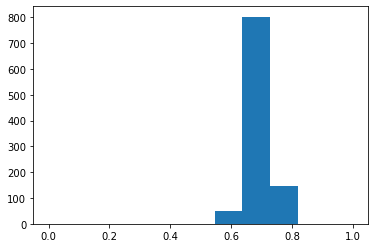

In [114]:
plt.hist(b_maxr, range=(0.00, 1), bins=int(b_bins))

(array([  0.,   0.,   0.,   0.,   0.,   6.,  61., 185., 232., 232., 143.,
         94.,  29.,  12.,   3.,   1.,   0.,   2.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]),
 array([0.02  , 0.0398, 0.0596, 0.0794, 0.0992, 0.119 , 0.1388, 0.1586,
        0.1784, 0.1982, 0.218 , 0.2378, 0.2576, 0.2774, 0.2972, 0.317 ,
        0.3368, 0.3566, 0.3764, 0.3962, 0.416 , 0.4358, 0.4556, 0.4754,
        0.4952, 0.515 , 0.5348, 0.5546, 0.5744, 0.5942, 0.614 , 0.6338,
        0.6536, 0.6734, 0.6932

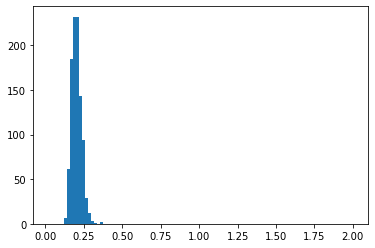

In [115]:
plt.hist(beta_maxr, range=(0.02, 2), bins=int(beta_bins))

-----
# Create median values for plotting graphs

In [116]:
# find median values of the best fit regressions

r2_median = np.nanmedian(r_maximum**2)
b_median = np.nanmedian(b_maxr)
beta_median = np.nanmedian(beta_maxr)
intercept_median = np.nanmedian(intercept_max)
slope_median = np.nanmedian(slope_max)



## tj you are slightly inconsistent here. 
we want r2, not r. we also don't want to use the median intercept, 
#but a median of a transformation of the intercept - kappa. which you do later. 

# Calculate alpha(si) and alpha(ic) values from the median beta, intercept and slope values
where kappa = e^intercept and gamma = slope of the line

y = Foc(z/1000)

x = Fic * beta(Fsi))^gamma

and: beta is ~ to a_si/a_ic

### therefore:

if: y = k * (beta * x^gamma)

beta = alpha_si/alpha_ic

alpha_ic = kappa^(1/gamma)

alpha_si = beta * kappa^(1/gamma)

k(kappa) = e^(intercept) and gamma = slope

the equation becomes Foc = (alpha_ic Fic + alpha_si Fsi)^gamma (z/1000)^b. so beta = alpha_si/alpha_ic.


In [117]:
kappa = np.exp(intercept_max)
kappa_median = np.nanmedian(np.exp(intercept_max))

In [118]:
a_ic_1 = kappa**(1/slope_median)
a_si_1 = beta_median*kappa**(1/slope_median)

In [119]:
a_ic = kappa_median**(1/slope_median)
a_si = beta_median*kappa_median**(1/slope_median)

In [120]:
print(a_ic)
print(a_si)

1.0209107376577486
0.2143912549081272


In [121]:
print('r2:        ', r2_median)
print('b:         ', b_median)
print('beta:         ', beta_median)
# print('a_ic:      ', a_ic)
# print('a_si:      ', a_si)
print('median intercept aka A: ', intercept_median)
print('gamma aka slope     ', slope_median)
print(f'kapppa aka median(exp(intercept)) {kappa_median}') 

r2:         0.7875178504990068
b:          0.7000000000000003
beta:          0.20999999999999996
median intercept aka A:  0.017821532960709596
gamma aka slope      0.8611471381997229
kapppa aka median(exp(intercept)) 1.017981284993401


-----
### Create values for plotting graphs

In [122]:
forjoesouth.shape

(768, 6)

In [123]:
log_y = np.log(forjoesouth[:,3]) + (b_median * np.subtract(np.log(forjoesouth[:,0]),np.log(1000)))
log_x = np.log(kappa_median**slope_median*((forjoesouth[:,4]) + (beta_median * forjoesouth[:,5])))

y = np.exp(log_y)
x = np.exp(log_x)

scale = forjoesouth[:,4] / forjoesouth[:,5]


/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [124]:
x_line = [0.00001, np.max(x)+10000]
y_line = kappa_median*x_line**slope_median

## TJ use actual calculated numbers in plot annotation 

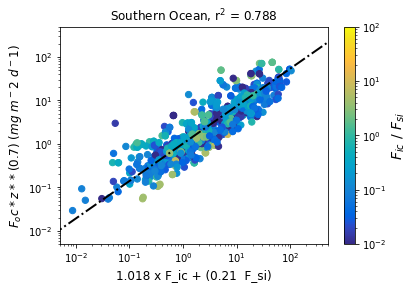

In [125]:
ax = plt.gca()
plt.plot(x_line, y_line, color='black', ls='-.', lw=2)
g = ax.scatter(x, y, c=scale, cmap=parula_map, norm=matplotlib.colors.LogNorm(vmin=0.01, vmax=100), s=40)
ax.set_yscale('log')
ax.set_xscale('log')
#plt.ylim(1e-2, 316.227766017)
#plt.xlim(0.00316227766, 600)
#axis([.005 500 .005 500])
plt.ylim(.005, 500)
plt.xlim(.005, 500)
cbar = plt.colorbar(g)

#use f strings 
#plt.title(r'$Southern \ Ocean \ (r^{2} = 0.89)$', size=16)
plt.title(f'Southern Ocean, r$^2$ = {round(r2_median, 3)}')

plt.ylabel(f'$F_oc * z ** ( {round(b_median, 3)}) \ (mg \ m^{-2} \ d^{-1})$', size=12) 

plt.xlabel(f'{round(kappa_median, 3)} x F_ic + ({round(beta_median, 3)}  F_si)', size=12)

cbar.set_label(r'${F_{ic}} \ / \ {F_{si}}$', size=14)

plt.show()